In [2]:
import os
file_list = os.listdir("../input")

# Data Loading and Preparation

In [3]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB


In [4]:
# load and view data
df = pd.read_csv("/kaggle/input/sampled-dataset-500k/US_Accidents_March23_sampled_500k.csv")
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,...,False,False,False,False,True,False,Day,Day,Day,Day
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,...,False,False,False,False,True,False,Day,Day,Day,Day
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,...,False,False,False,False,False,False,Night,Night,Night,Night


In [5]:
# mutate across latitude and longitude
df.loc[:, df.columns.str.contains('Lng')] = df.loc[:, df.columns.str.contains('Lng')].replace([0], [None])
df.loc[:, df.columns.str.contains('Lat')] = df.loc[:, df.columns.str.contains('Lat')].replace([0], [None])

In [6]:
# weather binning
weather_bins = {
    'Clear': ['Fair', 'Clear', 'N/A Precipitation'],
    'Cloudy': ['Mostly Cloudy', 'Cloudy', 'Partly Cloudy', 'Overcast', 'Scattered Clouds', 'Cloudy / Windy',
               'Partly Cloudy / Windy', 'Mostly Cloudy / Windy'],
    'Tornado': ['Funnel Cloud', 'Tornado'],
    'Sand and Dust': ['Blowing Dust / Windy', 'Blowing Dust', 'Widespread Dust', 'Widespread Dust / Windy',
                      'Sand / Dust Whirls Nearby', 'Sand / Dust Whirlwinds', 'Sand / Windy',
                      'Sand / Dust Whirlwinds / Windy', 'Blowing Sand'],
    'Hail': ['Small Hail', 'Hail', 'Thunder and Hail', 'Thunder and Hail / Windy',
             'Heavy Thunderstorms with Small Hail'],
    'Fog and Haze': ['Fog', 'Haze', 'Mist', 'Shallow Fog', 'Light Freezing Fog', 'Smoke', 'Fog / Windy',
                     'Haze / Windy', 'Drizzle and Fog', 'Patches of Fog', 'Smoke / Windy',
                     'Shallow Fog / Windy', 'Partial Fog', 'Patches of Fog / Windy'],
    'Icy': ['Light Freezing Drizzle', 'Light Freezing Rain', 'Light Ice Pellets', 'Ice Pellets',
            'Wintry Mix', 'Freezing Rain / Windy', 'Light Freezing Fog', 'Heavy Ice Pellets',
            'Thunder / Wintry Mix', 'Light Snow and Sleet', 'Thunder / Wintry Mix / Windy',
            'Snow and Sleet', 'Freezing Rain', 'Wintry Mix / Windy', 'Light Freezing Rain / Windy',
            'Snow and Sleet / Windy', 'Sleet and Thunder', 'Light Sleet', 'Sleet', 'Heavy Freezing Drizzle',
            'Heavy Sleet and Thunder', 'Freezing Drizzle', 'Light Sleet / Windy', 'Sleet / Windy',
            'Heavy Sleet', 'Light Snow and Sleet / Windy', 'Heavy Sleet / Windy', 'Snow Grains',
            'Heavy Freezing Rain'],
    'Stormy': ['Thunder', 'Thunder in the Vicinity', 'Light Rain with Thunder',
               'Heavy Thunderstorms and Snow', 'Light Thunderstorms and Rain', 'Thunderstorms and Rain',
               'Light Thunderstorms and Snow', 'T-Storm', 'Heavy Thunderstorms and Rain', 'Heavy T-Storm',
               'Thunderstorm', 'Heavy T-Storm / Windy', 'Thunder / Wintry Mix',
               'Thunder / Wintry Mix / Windy', 'T-Storm / Windy', 'Light Snow with Thunder',
               'Heavy Snow with Thunder', 'Thunder / Windy', 'Sleet and Thunder',
               'Heavy Sleet and Thunder', 'Snow and Thunder', 'Heavy Sleet and Thunder', 'Thunder and Hail',
               'Thunder and Hail / Windy', 'Heavy Rain Shower / Windy', 'Snow and Thunder / Windy',
               'Heavy Thunderstorms with Small Hail'],
    'Rainy': ['Light Rain', 'Light Drizzle', 'Rain', 'Drizzle', 'Heavy Rain', 'Light Rain with Thunder',
              'Light Thunderstorms and Rain', 'Thunderstorms and Rain', 'Rain / Windy', 'Wintry Mix',
              'Heavy Thunderstorms and Rain', 'Light Rain / Windy', 'Heavy Rain / Windy',
              'Heavy Drizzle', 'Showers in the Vicinity', 'Thunder / Wintry Mix',
              'Thunder / Wintry Mix / Windy', 'Wintry Mix / Windy', 'Light Drizzle / Windy', 'Drizzle and Fog',
              'Light Rain Shower', 'Drizzle / Windy', 'Light Rain Shower / Windy', 'Rain Shower',
              'Heavy Rain Shower', 'Light Rain Showers'],
    'Snowy': ['Snow', 'Light Snow', 'Heavy Snow', 'Heavy Thunderstorms and Snow', 'Blowing Snow',
              'Light Thunderstorms and Snow', 'Wintry Mix', 'Light Snow / Windy', 'Heavy Snow / Windy',
              'Light Snow and Sleet', 'Thunder / Wintry Mix / Windy', 'Snow and Sleet', 'Wintry Mix / Windy',
              'Snow / Windy', 'Snow and Sleet / Windy', 'Light Snow with Thunder', 'Light Snow Shower',
              'Heavy Snow with Thunder', 'Blowing Snow / Windy', 'Drifting Snow / Windy',
              'Snow and Thunder', 'Light Snow and Sleet / Windy', 'Light Snow Shower / Windy',
              'Snow and Thunder / Windy', 'Blowing Snow Nearby', 'Drifting Snow', 'Light Blowing Snow'],
    'Windy': ['Fair / Windy', 'Blowing Snow', 'Cloudy / Windy', 'Rain / Windy', 'Partly Cloudy / Windy',
              'Light Rain / Windy', 'Blowing Dust / Windy', 'Blowing Dust', 'Freezing Rain / Windy',
              'Mostly Cloudy / Windy', 'Light Snow / Windy', 'Heavy Snow / Windy', 'Heavy Rain / Windy',
              'Heavy T-Storm / Windy', 'Fog / Windy', 'Thunder / Wintry Mix',
              'Thunder / Wintry Mix / Windy', 'Haze / Windy', 'T-Storm / Windy', 'Wintry Mix / Windy',
              'Snow / Windy', 'Light Drizzle / Windy', 'Light Freezing Rain / Windy', 'Snow and Sleet / Windy',
              'Drizzle / Windy', 'Blowing Snow / Windy', 'Thunder / Windy', 'Squalls', 'Smoke / Windy',
              'Widespread Dust / Windy', 'Drifting Snow / Windy', 'Light Sleet / Windy',
              'Sleet / Windy', 'Light Snow and Sleet / Windy', 'Shallow Fog / Windy', 'Squalls / Windy']
}

def map_weather_to_bins(weather):
    for bin_name, conditions in weather_bins.items():
        if weather in conditions:
            return bin_name
    return 'Other'

df['Weather_Bin'] = df['Weather_Condition'].apply(map_weather_to_bins)

In [7]:
# pressure and visibility binning
df['Pressure_Category'] = pd.cut(df['Pressure(in)'], bins=[0, 29.8, 30.2, 100], labels=['Low', 'Normal', 'High'])
df['Visibility_Category'] = pd.cut(df['Visibility(mi)'], bins=[0, 1, 5, 100], labels=['Poor', 'Moderate', 'Clear'])

# make severity categorical
df['Severity'] = df['Severity'].astype('category')

In [8]:
# rush hour
df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='mixed')
df['End_Time'] = pd.to_datetime(df['End_Time'], format='mixed')

def categorize_rush_hour(start_time):
    try:        
        if 6 <= start_time.hour < 10:  # morning rush hours from 6 AM to 10 AM
            return True
        elif 16 <= start_time.hour < 19:  # evening rush hours from 4 PM to 7 PM
            return True
        else:
            return False
    except AttributeError:
        return 'No'
    
df['Is_Rush_Hour'] = df['Start_Time'].apply(categorize_rush_hour)

In [9]:
# accident duration
df['Accident_Duration'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60

In [10]:
# remove unnecessary columns, drop NAs
cols_to_drop = ['ID', 'Source', 'Country', 'Turning_Loop', 'Description', 'Pressure(in)', 'Visibility(mi)', 'Weather_Condition']
df.drop(columns=cols_to_drop, inplace=True)
df.dropna(inplace=True)

In [11]:
list(df.columns)

['Severity',
 'Start_Time',
 'End_Time',
 'Start_Lat',
 'Start_Lng',
 'End_Lat',
 'End_Lng',
 'Distance(mi)',
 'Street',
 'City',
 'County',
 'State',
 'Zipcode',
 'Timezone',
 'Airport_Code',
 'Weather_Timestamp',
 'Temperature(F)',
 'Wind_Chill(F)',
 'Humidity(%)',
 'Wind_Direction',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Sunrise_Sunset',
 'Civil_Twilight',
 'Nautical_Twilight',
 'Astronomical_Twilight',
 'Weather_Bin',
 'Pressure_Category',
 'Visibility_Category',
 'Is_Rush_Hour',
 'Accident_Duration']

# Exploratory Data Analysis

## Location Analysis

There are 7433 cities with accidents in the data.
City
Miami          9204
Los Angeles    5190
Orlando        4783
Dallas         3211
Houston        3016
Charlotte      2659
San Diego      2075
Raleigh        1950
Nashville      1865
Sacramento     1833
Minneapolis    1756
Baton Rouge    1716
Austin         1612
Tucson         1451
New Orleans    1422
Richmond       1416
Phoenix        1386
Atlanta        1364
Portland       1266
Saint Paul     1251
Name: count, dtype: int64


<Axes: xlabel='City'>

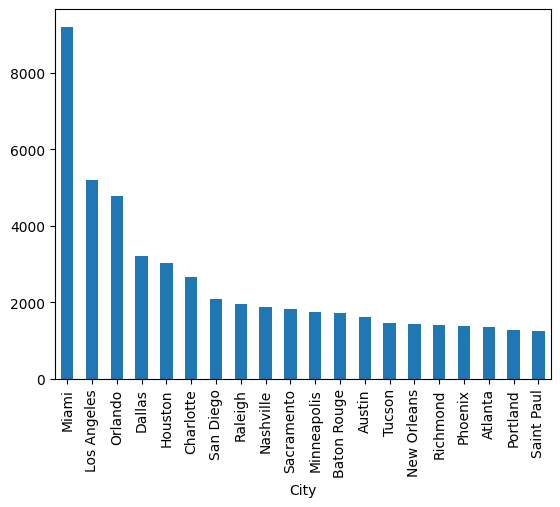

In [12]:
# top 20 cities
cities = df['City'].unique()
print(f"There are {len(cities)} cities with accidents in the data.")

accidents_by_city = df['City'].value_counts()
print(accidents_by_city.head(20))
accidents_by_city.head(20).plot(kind='bar')

State
CA    57338
FL    34051
TX    11503
VA    11244
NY    10938
PA    10555
SC     8758
NC     8542
OR     8011
MN     7551
TN     4876
AZ     4875
NJ     4567
LA     4421
MD     4327
MI     3588
GA     3539
UT     3005
IL     2641
CT     2627
Name: count, dtype: int64


<Axes: xlabel='State'>

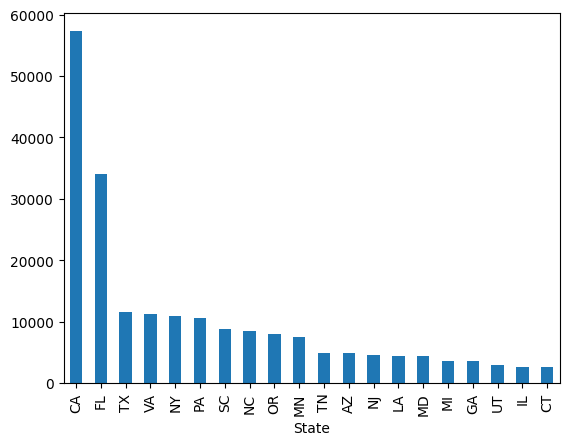

In [13]:
# top 20 states
states = df['State'].unique()
accidents_by_state = df['State'].value_counts()
print(accidents_by_state.head(20))
accidents_by_state.head(20).plot(kind='bar')

## Date/Time Analysis

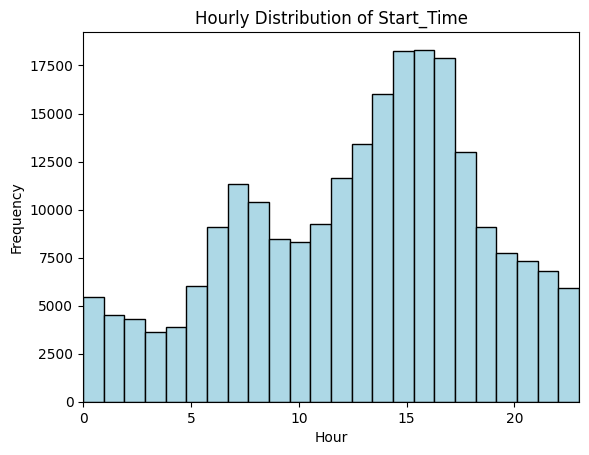

In [14]:
# accidents per hour
df['Hour'] = pd.to_datetime(df['Start_Time'], format='mixed').dt.hour
plt.hist(df['Hour'], bins=24, color='lightblue', edgecolor='black')
plt.title("Hourly Distribution of Start_Time")
plt.xlabel("Hour")
plt.ylabel("Frequency")
plt.xlim(0, 23)
plt.show()

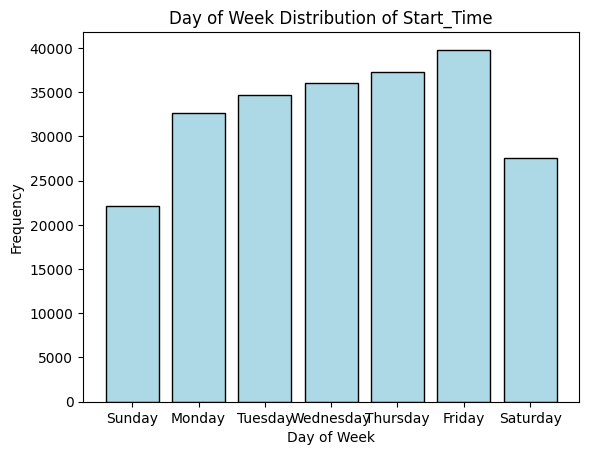

In [15]:
# accidents per day of week
df['DayOfWeek'] = pd.to_datetime(df['Start_Time'], format='mixed').dt.day_name()
day_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
accidents_by_weekday = df['DayOfWeek'].value_counts().reindex(day_order)
plt.bar(accidents_by_weekday.index, accidents_by_weekday, color='lightblue', edgecolor='black')
plt.title("Day of Week Distribution of Start_Time")
plt.xlabel("Day of Week")
plt.ylabel("Frequency")
plt.show()

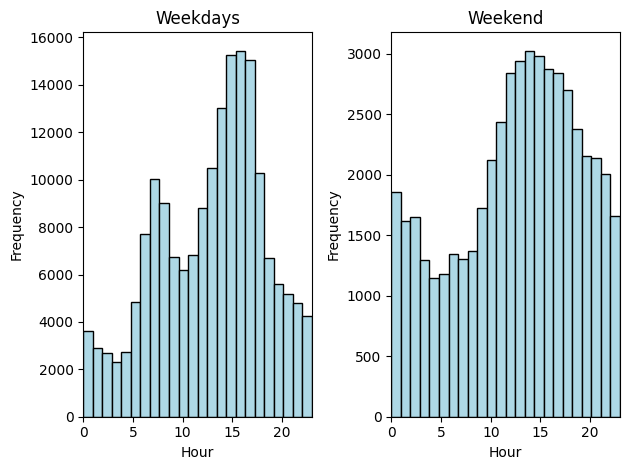

In [16]:
# weekend vs weekdays comparison
weekend = df[df['DayOfWeek'].isin(['Saturday', 'Sunday'])]
weekday = df[~df['DayOfWeek'].isin(['Saturday', 'Sunday'])]

plt.subplot(1, 2, 1)
plt.hist(weekday['Hour'], bins=24, color='lightblue', edgecolor='black')
plt.title("Weekdays")
plt.xlabel("Hour")
plt.ylabel("Frequency")
plt.xlim(0, 23)

plt.subplot(1, 2, 2)
plt.hist(weekend['Hour'], bins=24, color='lightblue', edgecolor='black')
plt.title("Weekend")
plt.xlabel("Hour")
plt.ylabel("Frequency")
plt.xlim(0, 23)
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

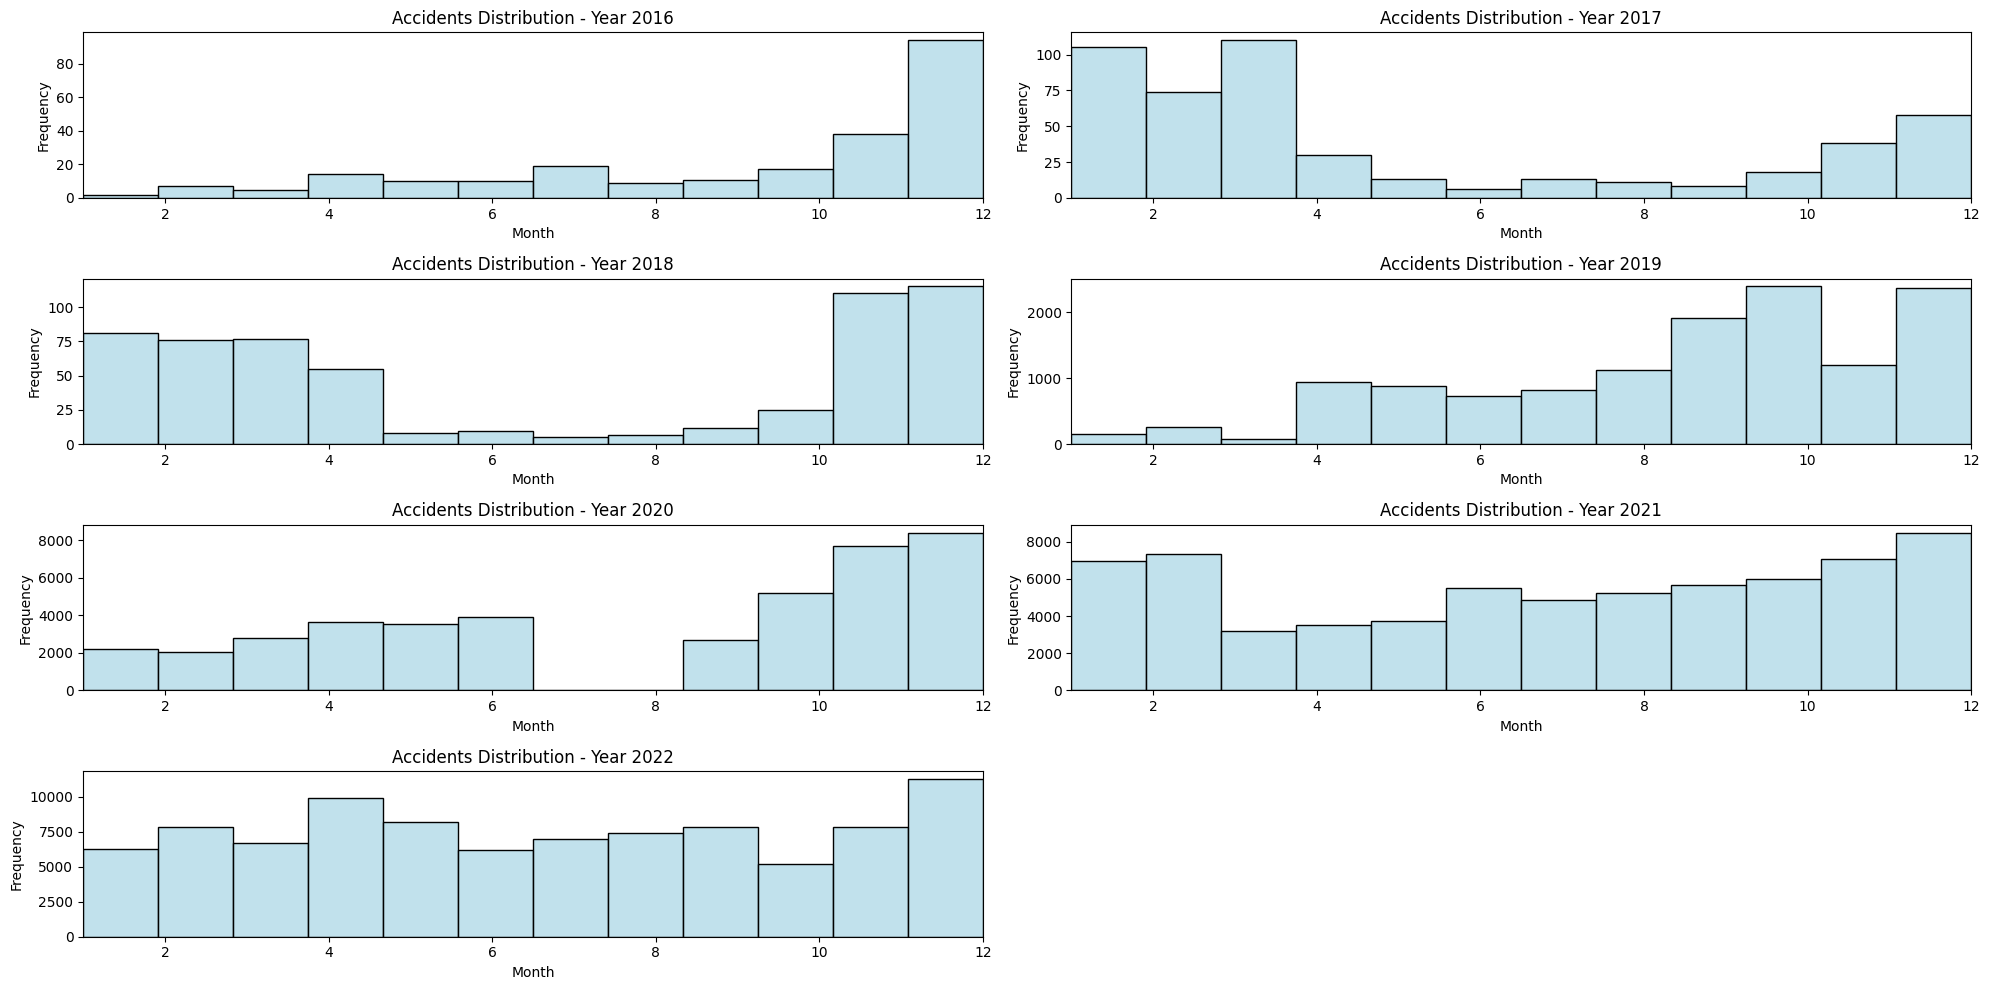

In [17]:
# monthly comparison by year
df['Year'] = pd.to_datetime(df['Start_Time'], format='mixed').dt.year
df['Month'] = pd.to_datetime(df['Start_Time'], format='mixed').dt.month
plt.figure(figsize=(20, 10))
for i, year in enumerate(range(2016, 2023), 1):
    plt.subplot(4, 2, i)
    sns.histplot(df[df['Year'] == year]['Month'], bins=12, color='lightblue', edgecolor='black', kde=False)
    plt.title(f"Accidents Distribution - Year {year}")
    plt.xlabel("Month")
    plt.ylabel("Frequency")
    plt.xlim(1, 12)
plt.tight_layout()
plt.show()

## Weather Analysis

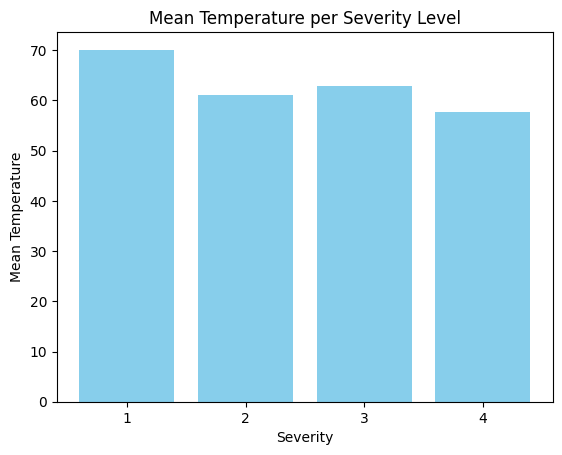

In [18]:
# temperature by severity
mean_temperature = df.groupby('Severity', observed=False)['Temperature(F)'].mean()
plt.bar(mean_temperature.index.astype(str), mean_temperature, color='skyblue')
plt.title("Mean Temperature per Severity Level")
plt.xlabel("Severity")
plt.ylabel("Mean Temperature")
plt.show()

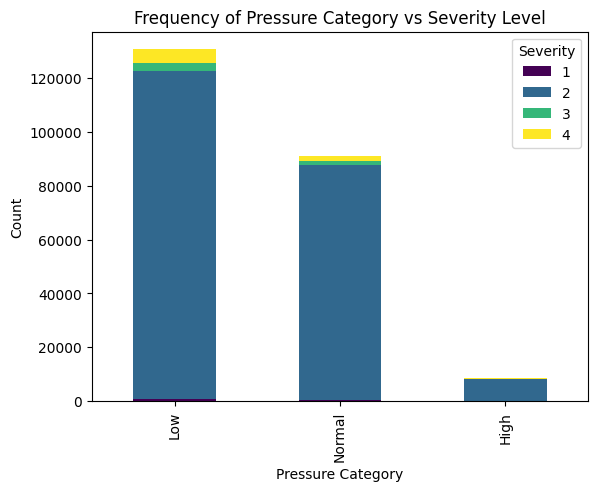

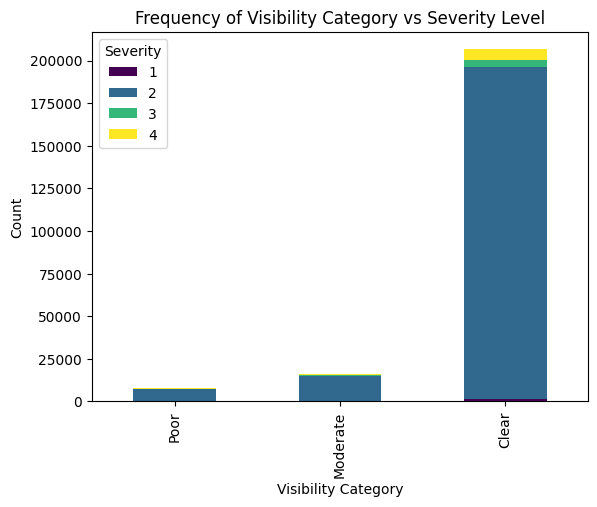

In [19]:
# pressure and visibility comparison
pd.crosstab(df['Pressure_Category'], df['Severity']).plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Frequency of Pressure Category vs Severity Level")
plt.xlabel("Pressure Category")
plt.ylabel("Count")

pd.crosstab(df['Visibility_Category'], df['Severity']).plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Frequency of Visibility Category vs Severity Level")
plt.xlabel("Visibility Category")
plt.ylabel("Count")
plt.show()

## Numeric Variable Correlation

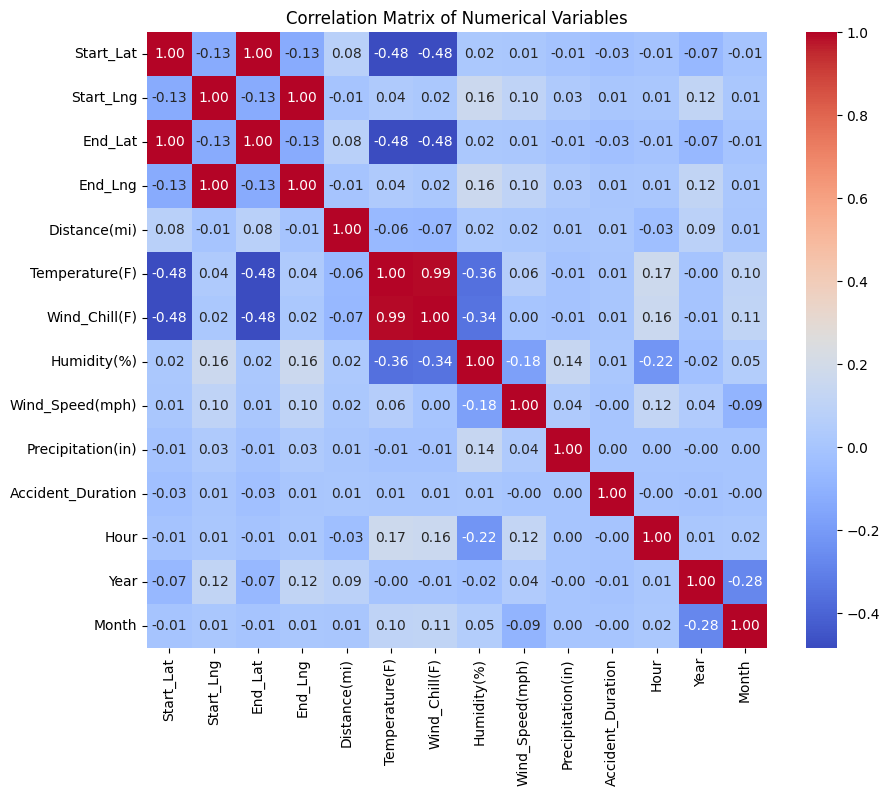

In [20]:
# correlation matrix of numerical variables
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

# note that the Lng and Lat columns will be removed after clustering, so their high correlation (which is obvious) won't affect the model

# Feature Engineering

In [21]:
# remove windchill and humidity as they are highly correlated with temperature
df.drop(columns=['Start_Time', 'End_Time', 'Hour', 'Month', 'Year', 'DayOfWeek', 'Weather_Timestamp', 'Wind_Chill(F)', 'Humidity(%)'], inplace=True)

## Cluster Creation

### Start Longitude/Latitude

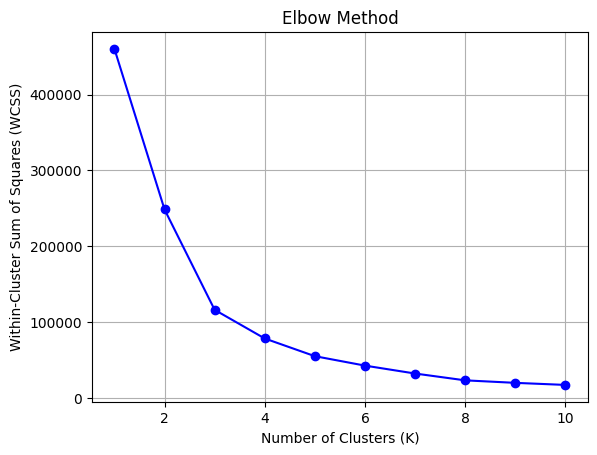

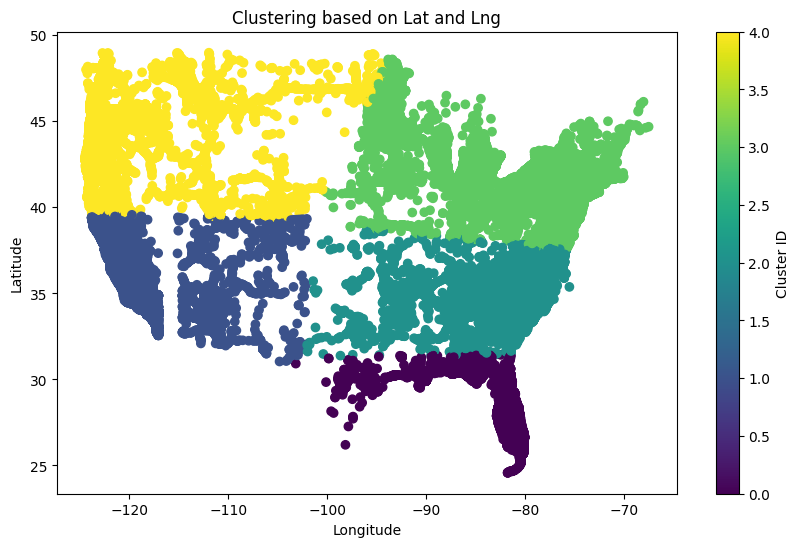

[3 1 4 0 2]


In [22]:
# scaling data
scaler = StandardScaler()
X = df[['Start_Lat', 'Start_Lng']]
scaled_X = scaler.fit_transform(X)

# WCSS method to find optimal number of clusters
wcss = []
max_clusters = 10
for i in range(1, max_clusters + 1):
    kmeans_model = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans_model.fit(scaled_X)
    wcss.append(kmeans_model.inertia_)

# plot elbow method
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-', color='blue')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.grid(True)
plt.show()

# k-means clustering
k = 5
kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
df['cluster_LatLng'] = kmeans_model.fit_predict(scaled_X)

# plot clusters
plt.figure(figsize=(10, 6))
plt.scatter(df['Start_Lng'], df['Start_Lat'], c=df['cluster_LatLng'], cmap='viridis')
plt.title('Clustering based on Lat and Lng')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster ID')
plt.show()

# print cluster numbers
print(df['cluster_LatLng'].unique())

### Airport Code

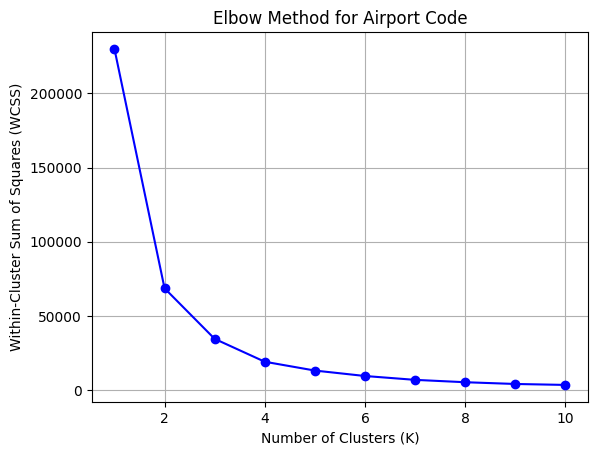

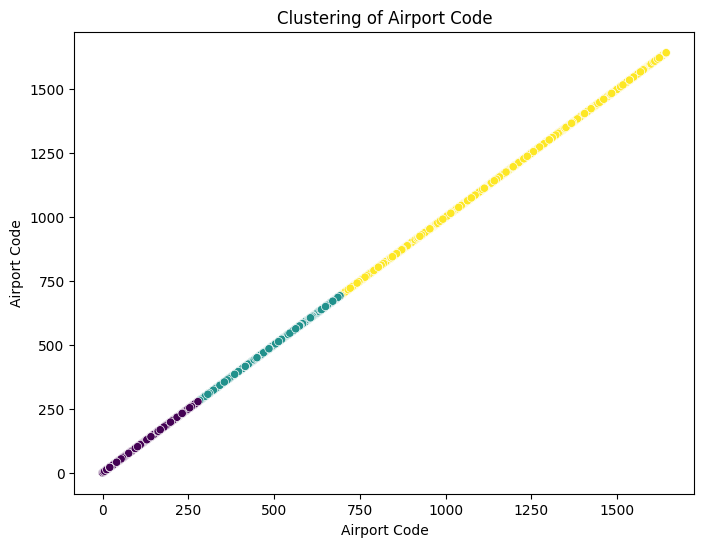

[0 1 2]


In [23]:
# convert Airport_Code to numeric
df['Airport_Code'] = pd.factorize(df['Airport_Code'])[0]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['Airport_Code']])

# WCSS method to find optimal number of clusters
wcss = []
max_clusters = 10
for i in range(1, max_clusters + 1):
    kmeans_model = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans_model.fit(scaled_data)
    wcss.append(kmeans_model.inertia_)

# plot elbow method
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-', color='blue')
plt.title("Elbow Method for Airport Code")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.grid(True)
plt.show()

# k-means clustering
k = 3
kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
df['cluster_Airport_Code'] = kmeans_model.fit_predict(scaled_data)

# plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Airport_Code', y='Airport_Code', hue='cluster_Airport_Code', data=df, palette='viridis', legend=None)
plt.title('Clustering of Airport Code')
plt.xlabel('Airport Code')
plt.ylabel('Airport Code')
plt.show()

# print cluster information
print(df['cluster_Airport_Code'].unique())

### Zipcode

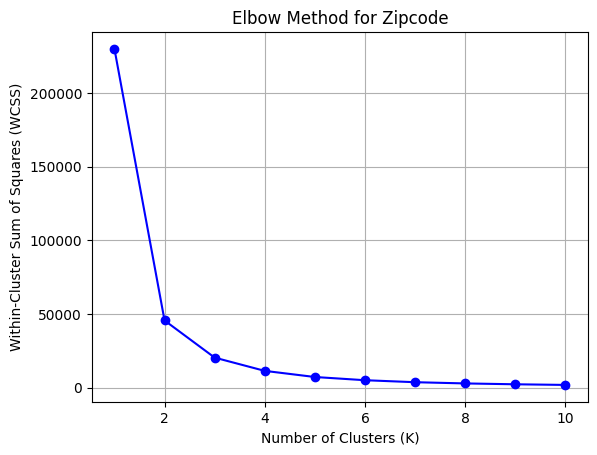

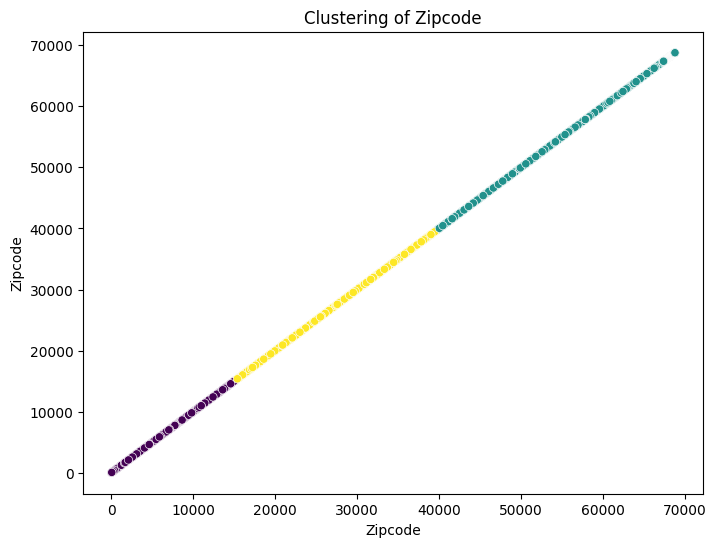

[0 2 1]


In [24]:
# standardize data
df['Zipcode'] = pd.factorize(df['Zipcode'])[0]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['Zipcode']])

# WCSS method to find optimal number of clusters
wcss = []
max_clusters = 10
for i in range(1, max_clusters + 1):
    kmeans_model = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans_model.fit(scaled_data)
    wcss.append(kmeans_model.inertia_)

# plot elbow method
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-', color='blue')
plt.title("Elbow Method for Zipcode")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.grid(True)
plt.show()

# k-means clustering
k = 3
kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
df['cluster_Zipcode'] = kmeans_model.fit_predict(scaled_data)

# plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Zipcode', y='Zipcode', hue='cluster_Zipcode', data=df, palette='viridis', legend=None)
plt.title('Clustering of Zipcode')
plt.xlabel('Zipcode')
plt.ylabel('Zipcode')
plt.show()

# print cluster information
print(df['cluster_Zipcode'].unique())

### Street

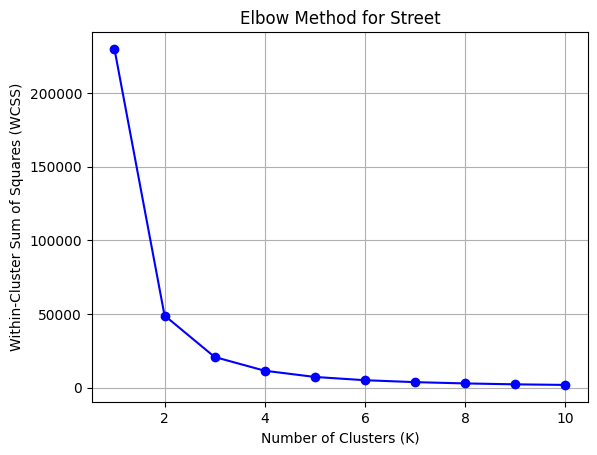

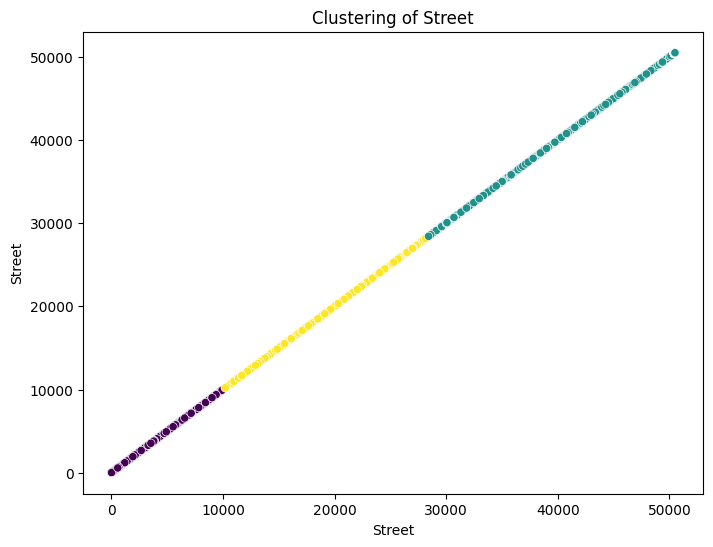

[0 2 1]


In [25]:
# convert street to numeric
df['Street'] = pd.factorize(df['Street'])[0]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['Street']])

# WCSS method to find optimal number of clusters
wcss = []
max_clusters = 10
for i in range(1, max_clusters + 1):
    kmeans_model = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans_model.fit(scaled_data)
    wcss.append(kmeans_model.inertia_)

# plot elbow method
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-', color='blue')
plt.title("Elbow Method for Street")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.grid(True)
plt.show()

# k-means clustering
k = 3
kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
df['cluster_Street'] = kmeans_model.fit_predict(scaled_data)

# plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Street', y='Street', hue='cluster_Street', data=df, palette='viridis', legend=None)
plt.title('Clustering of Street')
plt.xlabel('Street')
plt.ylabel('Street')
plt.show()

# print cluster information
print(df['cluster_Street'].unique())

### City

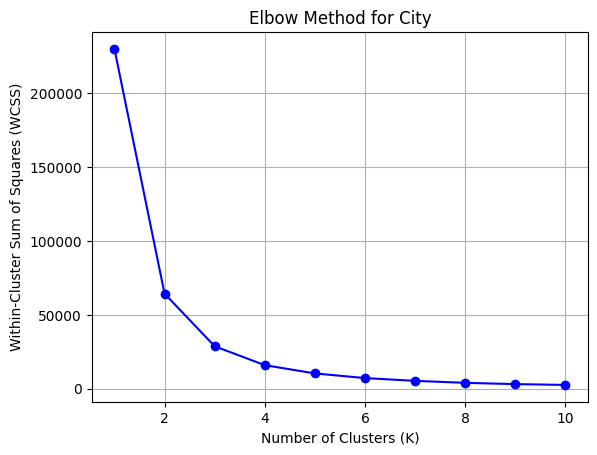

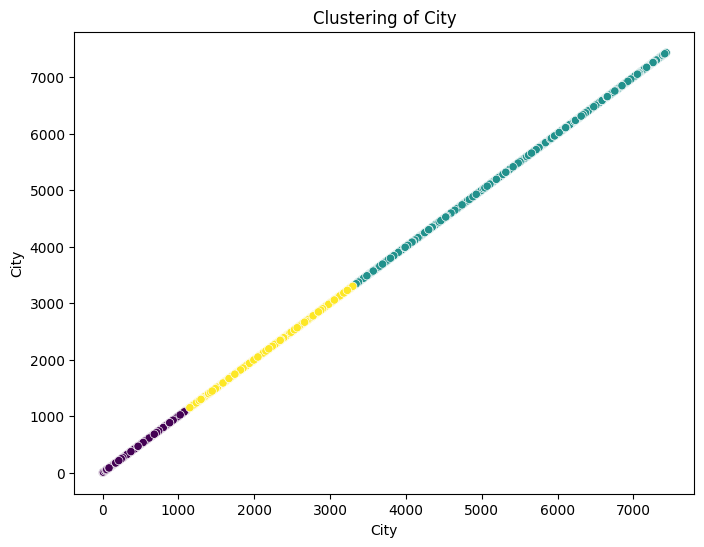

[0 2 1]


In [26]:
# convert city to numeric
df['City'] = pd.factorize(df['City'])[0]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['City']])

# WCSS method to find optimal number of clusters
wcss = []
max_clusters = 10
for i in range(1, max_clusters + 1):
    kmeans_model = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans_model.fit(scaled_data)
    wcss.append(kmeans_model.inertia_)

# plot elbow method
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-', color='blue')
plt.title("Elbow Method for City")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.grid(True)
plt.show()

# k-means clustering
k = 3
kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
df['cluster_City'] = kmeans_model.fit_predict(scaled_data)

# plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='City', y='City', hue='cluster_City', data=df, palette='viridis', legend=None)
plt.title('Clustering of City')
plt.xlabel('City')
plt.ylabel('City')
plt.show()

# print cluster information
print(df['cluster_City'].unique())

### County

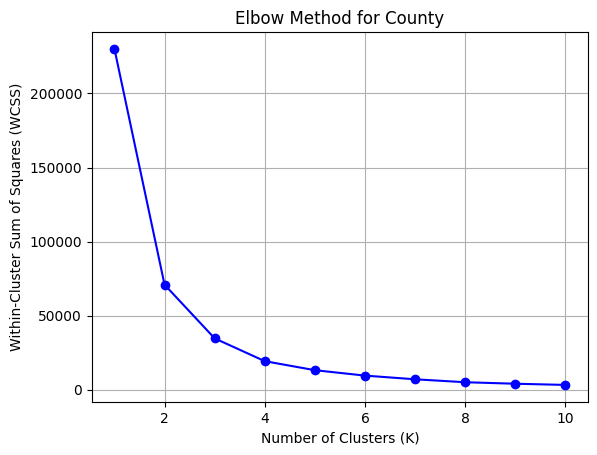

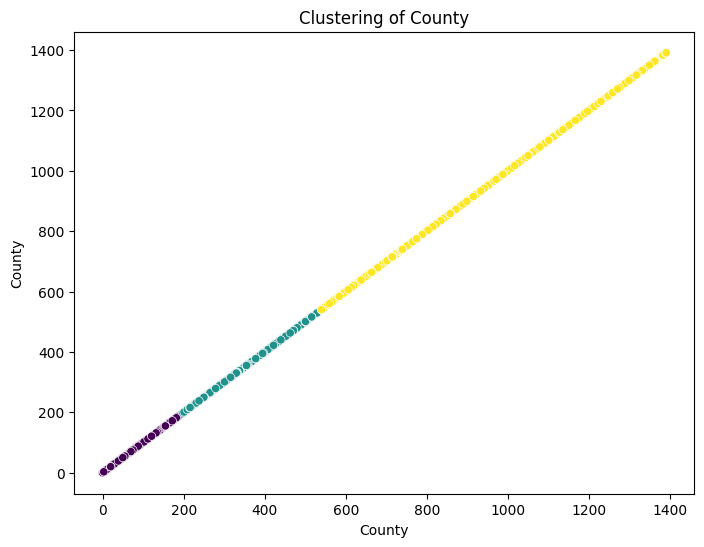

[0 1 2]


In [27]:
# standardize data
df['County'] = pd.factorize(df['County'])[0]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['County']])

# WCSS method to find optimal number of clusters
wcss = []
max_clusters = 10
for i in range(1, max_clusters + 1):
    kmeans_model = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans_model.fit(scaled_data)
    wcss.append(kmeans_model.inertia_)

# plot elbow method
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-', color='blue')
plt.title("Elbow Method for County")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.grid(True)
plt.show()

# k-means clustering
k = 3
kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
df['cluster_County'] = kmeans_model.fit_predict(scaled_data)

# plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='County', y='County', hue='cluster_County', data=df, palette='viridis', legend=None)
plt.title('Clustering of County')
plt.xlabel('County')
plt.ylabel('County')
plt.show()

# print cluster information
print(df['cluster_County'].unique())

In [28]:
# drop all columns used to cluster
df.drop(columns=['Start_Lat', 'End_Lat', 'Start_Lng', 'End_Lng', 'Airport_Code', 'Zipcode', 'Street', 'City', 'County'],inplace=True)

In [29]:
df.dtypes

Severity                 category
Distance(mi)              float64
State                      object
Timezone                   object
Temperature(F)            float64
Wind_Direction             object
Wind_Speed(mph)           float64
Precipitation(in)         float64
Amenity                      bool
Bump                         bool
Crossing                     bool
Give_Way                     bool
Junction                     bool
No_Exit                      bool
Railway                      bool
Roundabout                   bool
Station                      bool
Stop                         bool
Traffic_Calming              bool
Traffic_Signal               bool
Sunrise_Sunset             object
Civil_Twilight             object
Nautical_Twilight          object
Astronomical_Twilight      object
Weather_Bin                object
Pressure_Category        category
Visibility_Category      category
Is_Rush_Hour                 bool
Accident_Duration         float64
cluster_LatLng

# Handling Data Imbalance

## Random Undersampling

In [30]:
# label encoding for categorical variables
categorical_cols = df.select_dtypes(include=['object','bool','category']).columns

label_encoder = LabelEncoder()

for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

len(df.dtypes)

35

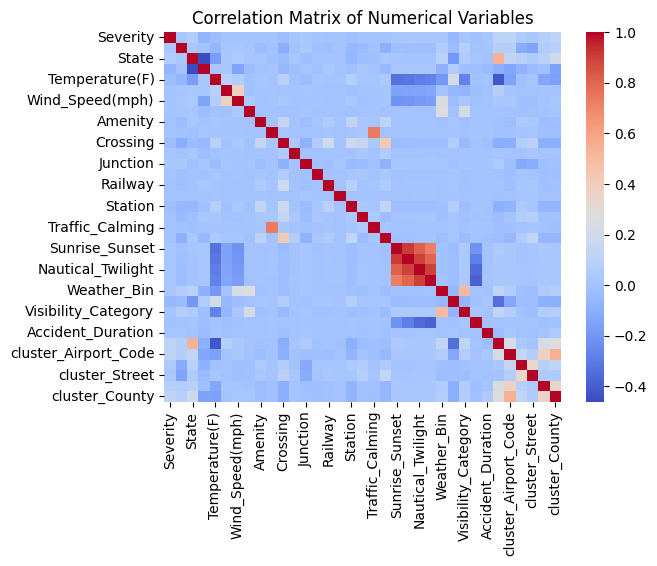

In [31]:
# remake correlation matrix
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

In [32]:
# drop any remaining highly-correlated variables
df.drop(columns=['Nautical_Twilight', 'Civil_Twilight', 'Astronomical_Twilight'],inplace=True)

## Principal Component Analysis

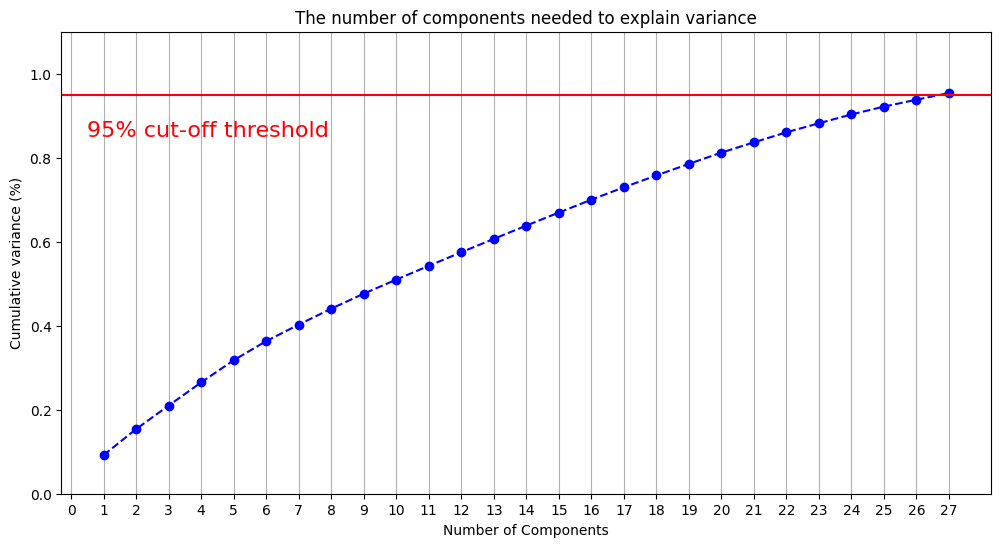

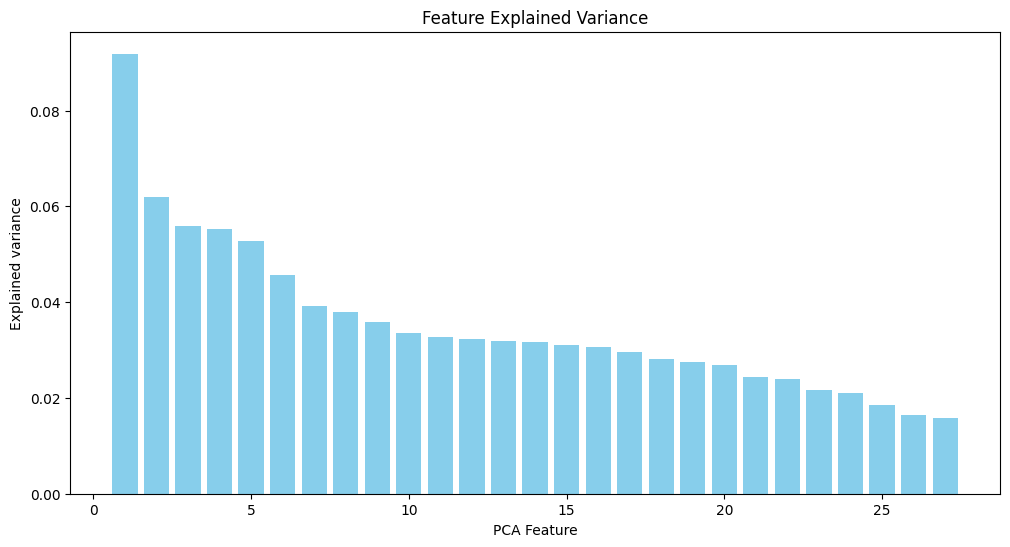

In [35]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Scaling the data
sc = StandardScaler()
X_train_scaled = sc.fit_transform(train_df.drop('Severity', axis=1))
X_test_scaled = sc.transform(test_df.drop('Severity', axis=1))

# Apply PCA
pca = PCA(n_components=27) 
X_train = pca.fit_transform(X_train_scaled)
y_train = train_df['Severity']

X_test = pca.transform(X_test_scaled)
y_test = test_df['Severity']

# Now, perform undersampling on the PCA-transformed data
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, train_df['Severity'])

# Plotting the cumulative variance explained by the 27 PCA components
plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
xi = np.arange(1, 28, step=1)
y = np.cumsum(pca.explained_variance_ratio_[:27])

plt.ylim(0.0, 1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 28, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color='red', fontsize=16)

ax.grid(axis='x')
plt.show()

# Plotting explained variance of each component
plt.figure(figsize=(12, 6))
plt.bar(range(1, 28), pca.explained_variance_ratio_[:27], color='skyblue')
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

# Creating a DataFrame for the principal components
principalDf = pd.DataFrame(data=X_train_resampled, columns=[f'Principal Component {i+1}' for i in range(27)])


# Model Building

## Logistic Regression

In [40]:
# WITHOUT PCA

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=123)

# Fitting the model
logistic_regression = LogisticRegression(random_state=1, max_iter=5000)
logistic_regression.fit(X_train, y_train)

# Testing the model
y_pred_test = logistic_regression.predict(X_test)
print("TEST")
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy_test:.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

# Validating the model
y_pred_valid = logistic_regression.predict(X_valid)
print("VALID")
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print(f"Accuracy: {accuracy_valid:.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred_valid))
print("Classification Report:")
print(classification_report(y_valid, y_pred_valid))

# WITH PCA

# Splitting the data again for PCA version
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.30, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=123)

# Scaling the data
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)
X_valid_scaled = sc.transform(X_valid)

# Applying PCA
pca = PCA(n_components=27)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_valid_pca = pca.transform(X_valid_scaled)

# Fitting the model on PCA-transformed data
logistic_regression_pca = LogisticRegression(random_state=123, max_iter=5000)
logistic_regression_pca.fit(X_train_pca, y_train)

# Testing the model
y_pred_test_pca = logistic_regression_pca.predict(X_test_pca)
print("TEST PCA")
accuracy_test_pca = accuracy_score(y_test, y_pred_test_pca)
print(f"Accuracy: {accuracy_test_pca:.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test_pca))
print("Classification Report:")
print(classification_report(y_test, y_pred_test_pca))

# Validating the model
y_pred_valid_pca = logistic_regression_pca.predict(X_valid_pca)
print("VALID PCA")
accuracy_valid_pca = accuracy_score(y_valid, y_pred_valid_pca)
print(f"Accuracy: {accuracy_valid_pca:.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred_valid_pca))
print("Classification Report:")
print(classification_report(y_valid, y_pred_valid_pca))

TEST
Accuracy: 0.44
Confusion Matrix:
[[58 23 25 12]
 [23 53 23 26]
 [22 24 46 18]
 [13 28 24 50]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.49      0.50       118
           1       0.41      0.42      0.42       125
           2       0.39      0.42      0.40       110
           3       0.47      0.43      0.45       115

    accuracy                           0.44       468
   macro avg       0.44      0.44      0.44       468
weighted avg       0.44      0.44      0.44       468

VALID
Accuracy: 0.49
Confusion Matrix:
[[73 21 22  8]
 [12 54 29 22]
 [25 21 47 14]
 [ 9 21 35 55]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       124
           1       0.46      0.46      0.46       117
           2       0.35      0.44      0.39       107
           3       0.56      0.46      0.50       120

    accuracy                           0.49     

## Random Forest

In [37]:
#WITHOUT PCA

#SPLITTING DATA
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=123)

#FITTING THE MODEL
rf_classifier = RandomForestClassifier(random_state=1)
rf_classifier.fit(X_train, y_train)  

# TEST

y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("TEST")
print(f"Accuracy: {accuracy:.2f}")

confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# VALID

y_pred = rf_classifier.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print("VALID")
print(f"Accuracy: {accuracy:.2f}")

confusion_mat = confusion_matrix(y_valid, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

class_report = classification_report(y_valid, y_pred)
print("Classification Report:")
print(class_report)

# With PCA

# SPLITTING THE DATA
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.30, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=123)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_valid = sc.transform(X_valid)
pca = PCA(n_components = 27)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
X_valid = pca.transform(X_valid)

#FITTING THE MODEL
rf_classifier = RandomForestClassifier(random_state=1)
rf_classifier.fit(X_train, y_train)  

rf_classifier.feature_importances_

# PREDICT
y_pred = rf_classifier.predict(X_valid)
y_pred = rf_classifier.predict(X_test)

# TEST

y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("TEST")
print(f"Accuracy: {accuracy:.2f}")

confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# VALID

y_pred = rf_classifier.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print("VALID")
print(f"Accuracy: {accuracy:.2f}")

confusion_mat = confusion_matrix(y_valid, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

class_report = classification_report(y_valid, y_pred)
print("Classification Report:")
print(class_report)

TEST
Accuracy: 0.48
Confusion Matrix:
[[61 18 30  9]
 [21 55 18 31]
 [21 24 51 14]
 [13 22 24 56]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.52      0.52       118
           1       0.46      0.44      0.45       125
           2       0.41      0.46      0.44       110
           3       0.51      0.49      0.50       115

    accuracy                           0.48       468
   macro avg       0.48      0.48      0.48       468
weighted avg       0.48      0.48      0.48       468

VALID
Accuracy: 0.49
Confusion Matrix:
[[68 16 30 10]
 [15 55 29 18]
 [21 18 56 12]
 [12 31 27 50]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.55      0.57       124
           1       0.46      0.47      0.46       117
           2       0.39      0.52      0.45       107
           3       0.56      0.42      0.48       120

    accuracy                           0.49     

## Naive Bayes

In [38]:
# WITHOUT PCA 
np.random.seed(1)

# SPLITTING THE DATA
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=123)

#FITTING THE MODEL
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# PREDICT
y_pred = nb_classifier.predict(X_valid)
y_pred = nb_classifier.predict(X_test)

# TEST

y_pred = nb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("TEST")
print(f"Accuracy: {accuracy:.2f}")

confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# VALID

y_pred = nb_classifier.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print("VALID")
print(f"Accuracy: {accuracy:.2f}")

confusion_mat = confusion_matrix(y_valid, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

class_report = classification_report(y_valid, y_pred)
print("Classification Report:")
print(class_report)

# WITH PCA 
np.random.seed(1)

# SPLITTING THE DATA
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.30, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=123)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_valid = sc.transform(X_valid)
pca = PCA(n_components = 27)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
X_valid = pca.transform(X_valid)

#FITTING THE MODEL
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# VALID

y_pred = nb_classifier.predict(X_valid)
y_pred = nb_classifier.predict(X_test)

# TEST

y_pred = nb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("TEST")
print(f"Accuracy: {accuracy:.2f}")

confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# VALID

y_pred = nb_classifier.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print("VALID")
print(f"Accuracy: {accuracy:.2f}")

confusion_mat = confusion_matrix(y_valid, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

class_report = classification_report(y_valid, y_pred)
print("Classification Report:")
print(class_report)

TEST
Accuracy: 0.45
Confusion Matrix:
[[60 38 16  4]
 [14 79 12 20]
 [21 34 41 14]
 [15 48 21 31]]
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.51      0.53       118
           1       0.40      0.63      0.49       125
           2       0.46      0.37      0.41       110
           3       0.45      0.27      0.34       115

    accuracy                           0.45       468
   macro avg       0.46      0.45      0.44       468
weighted avg       0.46      0.45      0.44       468

VALID
Accuracy: 0.45
Confusion Matrix:
[[69 36 15  4]
 [16 73 18 10]
 [26 35 37  9]
 [17 47 25 31]]
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.56      0.55       124
           1       0.38      0.62      0.47       117
           2       0.39      0.35      0.37       107
           3       0.57      0.26      0.36       120

    accuracy                           0.45     

## SVC

In [42]:
# WITHOUT PCA

# SPLITTING THE DATA
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=123)

# BUILDING THE MODEL 
model = SVC(random_state=123)
model.fit(X_train, y_train)

# PREDICT
y_pred = model.predict(X_valid)
y_pred = model.predict(X_test)

# TEST

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("TEST")
print(f"Accuracy: {accuracy:.2f}")

confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# VALID

y_pred = model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print("VALID")
print(f"Accuracy: {accuracy:.2f}")

confusion_mat = confusion_matrix(y_valid, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

class_report = classification_report(y_valid, y_pred)
print("Classification Report:")
print(class_report)

#WITH PCA

# SPLITTING THE DATA
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.30, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=123)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_valid = sc.transform(X_valid)
pca = PCA(n_components = 27)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
X_valid = pca.transform(X_valid)

# BUILDING THE MODEL 
model = SVC(random_state=123)
model.fit(X_train, y_train)

# PREDICT
y_pred = model.predict(X_valid)
y_pred = model.predict(X_test)

# TEST

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("TEST")
print(f"Accuracy: {accuracy:.2f}")

confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# VALID

y_pred = model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print("VALID")
print(f"Accuracy: {accuracy:.2f}")

confusion_mat = confusion_matrix(y_valid, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

class_report = classification_report(y_valid, y_pred)
print("Classification Report:")
print(class_report)

TEST
Accuracy: 0.47
Confusion Matrix:
[[55 21 30 12]
 [10 63 24 28]
 [20 23 51 16]
 [ 8 24 32 51]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.47      0.52       118
           1       0.48      0.50      0.49       125
           2       0.37      0.46      0.41       110
           3       0.48      0.44      0.46       115

    accuracy                           0.47       468
   macro avg       0.48      0.47      0.47       468
weighted avg       0.48      0.47      0.47       468

VALID
Accuracy: 0.51
Confusion Matrix:
[[70 18 28  8]
 [ 7 59 35 16]
 [15 22 60 10]
 [ 7 23 42 48]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.56      0.63       124
           1       0.48      0.50      0.49       117
           2       0.36      0.56      0.44       107
           3       0.59      0.40      0.48       120

    accuracy                           0.51     